In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [2]:
os.chdir('/kaggle/input/spotify-dataset/')

In [3]:
os.getcwd()

'/kaggle/input/spotify-dataset'

In [4]:
data='DATASET.csv'
df=pd.read_csv(data);

In [5]:
df.head()

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


In [6]:
df.isnull()

,Review,label
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
52697,False,False
52698,False,False
52699,False,False
52700,False,False


In [7]:
df.isnull().sum()

Review    16
label      0
dtype: int64

In [8]:
df.describe()

,Review,label
count,52686,52702
unique,51472,2
top,Good,NEGATIVE
freq,153,29423


In [9]:
print(df.columns)

Index(['Review', 'label'], dtype='object')


In [10]:
df['Review'] = df['Review'].fillna('')

In [11]:
print(df.isnull().sum())

Review    0
label     0
dtype: int64


In [12]:

oh = OneHotEncoder(sparse=False)
labels = oh.fit_transform(df['label'].values.reshape(-1, 1))



/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [13]:

X_train, X_test, y_train, y_test = train_test_split(df['Review'], labels, test_size=0.2, random_state=42)


In [14]:
# Calculate total number of words in all reviews
total_words = df['Review'].str.split().str.len().sum()

# Display the total
print("Total Number of Words in All Reviews:", total_words)


Total Number of Words in All Reviews: 1501406


In [15]:

tokenizer = Tokenizer(num_words=5000) 
tokenizer.fit_on_texts(X_train)


In [16]:

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)


In [17]:
# Calculate lengths of each review
df['review_length'] = df['Review'].apply(lambda x: len(x.split()))


In [18]:

# Display statistics
print(f"Maximum review length: {df['review_length'].max()}")
print(f"Average review length: {df['review_length'].mean()}")
print(f"Median review length: {df['review_length'].median()}")
print(f"95th percentile review length: {df['review_length'].quantile(0.95)}")

Maximum review length: 423
Average review length: 28.48859625820652
Median review length: 22.0
95th percentile review length: 80.0


In [25]:

max_length = 80  # Adjust based on your dataset
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [26]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Input

In [27]:
# LSTM Model
model = Sequential()
model.add(Input(shape=(max_length,)))  # Specify input shape
model.add(Embedding(input_dim=5000, output_dim=128))  # Embedding layer
model.add(LSTM(128, return_sequences=True))  # First LSTM layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(LSTM(64))  # Second LSTM layer
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Output layer

In [28]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [29]:
# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 80, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 80, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 821,122 (3.13 MB)

 Trainable params: 821,122 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model
history = model.fit(X_train_pad, y_train, epochs=15, batch_size=64, validation_split=0.2)


Epoch 1/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.6676 - loss: 0.6184 - val_accuracy: 0.7720 - val_loss: 0.5375
Epoch 2/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7001 - loss: 0.5885 - val_accuracy: 0.7732 - val_loss: 0.5314
Epoch 3/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7789 - loss: 0.5318 - val_accuracy: 0.7130 - val_loss: 0.5694
Epoch 4/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7125 - loss: 0.5585 - val_accuracy: 0.6445 - val_loss: 0.6042
Epoch 5/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7100 - loss: 0.5589 - val_accuracy: 0.8106 - val_loss: 0.4833
Epoch 6/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8165 - loss: 0.4313 - val_accuracy: 0.8590 - val_loss: 0.3389
Epoch 7/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8811 - loss: 0.3044 - val_accuracy: 0.8774 - val_loss: 0.3072
Epoch 8/15
527/527 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9092 - loss: 0.2454 - val_acc

In [31]:

loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8850 - loss: 0.3396
Test Accuracy: 0.8847


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


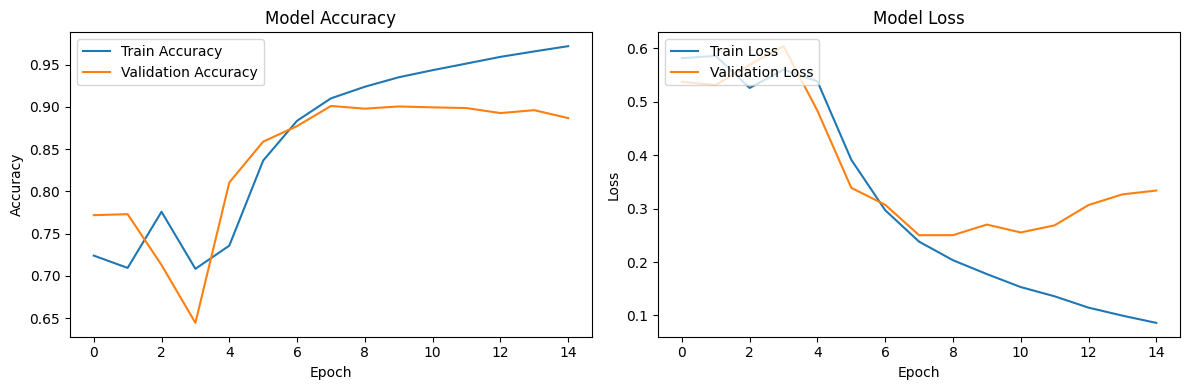

In [41]:

def plot_training_history(history):
  
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)


330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


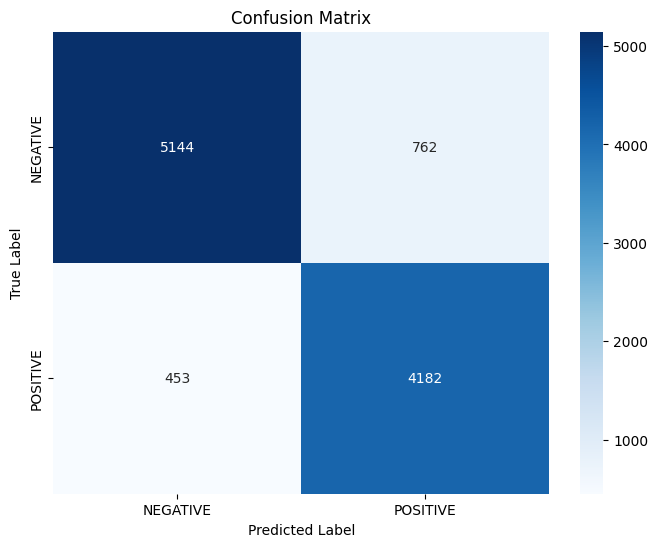

              precision    recall  f1-score   support

    NEGATIVE       0.92      0.87      0.89      5906
    POSITIVE       0.85      0.90      0.87      4635

    accuracy                           0.88     10541
   macro avg       0.88      0.89      0.88     10541
weighted avg       0.89      0.88      0.89     10541



In [38]:
# Assuming you have the predictions and true labels
y_pred = model.predict(X_test_pad)  # Use your test data
y_pred_classes = np.argmax(y_pred, axis=1)

# Assuming you have the true labels in y_test
# Convert y_test if it's one-hot encoded
y_test_classes = np.argmax(y_test, axis=1)  # Adjust if necessary

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['NEGATIVE', 'POSITIVE'], 
            yticklabels=['NEGATIVE', 'POSITIVE'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test_classes, y_pred_classes, target_names=['NEGATIVE', 'POSITIVE']))


In [39]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Predefined review
review = "I love the Spotify app ."

# Preprocess and predict sentiment
def predict_sentiment(review, model, tokenizer, max_length, encoder):
    padded = pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=max_length, padding='post')
    pred = model.predict(padded)
    return encoder.categories_[0][np.argmax(pred)]

# Get predicted sentiment
predicted_class = predict_sentiment(review, model, tokenizer, max_length, oh)

# Display result
print("Original Review:", review)
print("Predicted Sentiment:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Original Review: I love the Spotify app .
Predicted Sentiment: POSITIVE


In [40]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

# Predefined review
review = "This app is good but very slow. Loved the songs but hates when it crashes"

# Preprocess and predict sentiment
def predict_sentiment(review, model, tokenizer, max_length, encoder):
    padded = pad_sequences(tokenizer.texts_to_sequences([review]), maxlen=max_length, padding='post')
    pred = model.predict(padded)
    return encoder.categories_[0][np.argmax(pred)]

# Get predicted sentiment
predicted_class = predict_sentiment(review, model, tokenizer, max_length, oh)

# Display result
print("Original Review:", review)
print("Predicted Sentiment:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Original Review: This app is good but very slow. Loved the songs but hates when it crashes
Predicted Sentiment: NEGATIVE
